<a href="https://colab.research.google.com/github/MostafaJahanian/Free_Projects/blob/main/Coffee_Beans_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Getting colab session ready for importing dataset from Kaggle

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mostafajhn","key":"938cec14284697f7c385220fa9fa3cb9"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download gpiosenka/coffee-bean-dataset-resized-224-x-224

coffee-bean-dataset-resized-224-x-224.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip coffee-bean-dataset-resized-224-x-224.zip

Archive:  coffee-bean-dataset-resized-224-x-224.zip
  inflating: Coffee Bean.csv         
  inflating: test/Dark/dark (1).png  
  inflating: test/Dark/dark (10).png  
  inflating: test/Dark/dark (100).png  
  inflating: test/Dark/dark (11).png  
  inflating: test/Dark/dark (12).png  
  inflating: test/Dark/dark (13).png  
  inflating: test/Dark/dark (14).png  
  inflating: test/Dark/dark (15).png  
  inflating: test/Dark/dark (16).png  
  inflating: test/Dark/dark (17).png  
  inflating: test/Dark/dark (18).png  
  inflating: test/Dark/dark (19).png  
  inflating: test/Dark/dark (2).png  
  inflating: test/Dark/dark (20).png  
  inflating: test/Dark/dark (21).png  
  inflating: test/Dark/dark (22).png  
  inflating: test/Dark/dark (23).png  
  inflating: test/Dark/dark (24).png  
  inflating: test/Dark/dark (25).png  
  inflating: test/Dark/dark (26).png  
  inflating: test/Dark/dark (27).png  
  inflating: test/Dark/dark (28).png  
  inflating: test/Dark/dark (29).png  
  inflating: t

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pathlib
import cv2
import PIL
import random

### Creating sets from the original images

In [8]:
class_names = keras.utils.image_dataset_from_directory('train').class_names

Found 1200 files belonging to 4 classes.


In [9]:
train_directory = pathlib.Path('train')
test_directory = pathlib.Path('test')
len(list(train_directory.glob('*/*.png'))), len(list(test_directory.glob('*/*.png')))

(1200, 400)

In [10]:
train_dir, test_dir = [], []
for label in class_names:
  train_dir.append(train_directory.glob(f'{label}/*'))
  test_dir.append(test_directory.glob(f'{label}/*'))
len(train_dir)

4

In [11]:
train_dict = dict(zip(class_names, train_dir))
test_dict = dict(zip(class_names, test_dir))

In [12]:
X, y = [], []
for label in train_dict:
  for path in train_dict[label]:
    X.append(cv2.cvtColor((cv2.resize(cv2.imread(str(path)), (224, 224))), cv2.COLOR_BGR2RGB))
    y.append(class_names.index(label))

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1200, 224, 224, 3), (1200,))

In [13]:
X_test, y_test = [], []
for label in test_dict:
  for path in test_dict[label]:
    X_test.append(cv2.cvtColor((cv2.resize(cv2.imread(str(path)), (224, 224))), cv2.COLOR_BGR2RGB))
    y_test.append(class_names.index(label))

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test.shape, y_test.shape

((400, 224, 224, 3), (400,))

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 1)
X_train.shape, X_val.shape

((1080, 224, 224, 3), (120, 224, 224, 3))

### Getting data ready for training

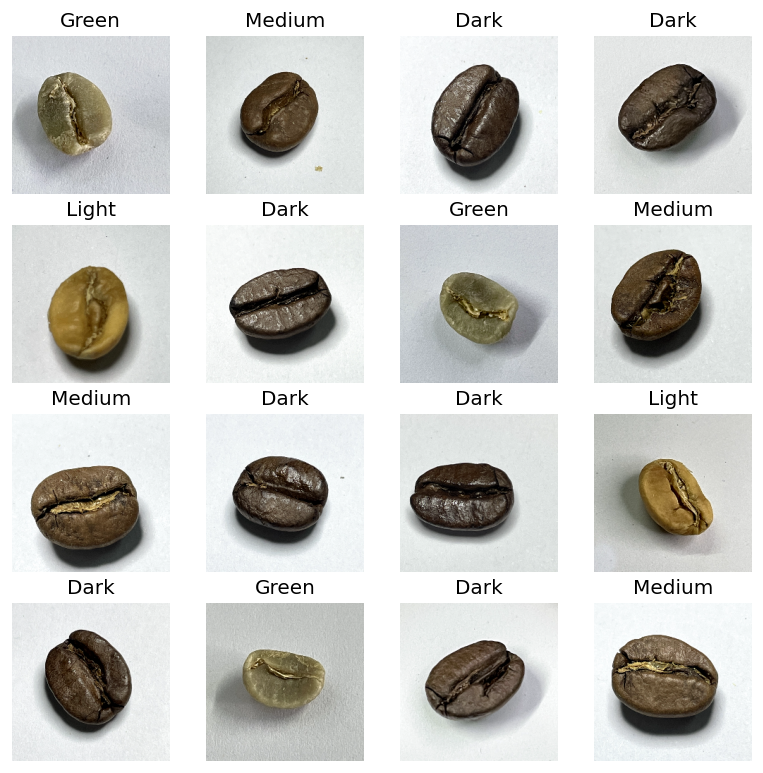

In [15]:
plt.figure(figsize = (8, 8), dpi = 120)
for i in range(16):
  index = random.randint(0, len(X_train))
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_train[index])
  plt.title(class_names[y_train[index]])
  plt.axis(False)

In [16]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train), 224*224*3)).reshape(X_train.shape)
X_train_scaled.shape

(1080, 224, 224, 3)

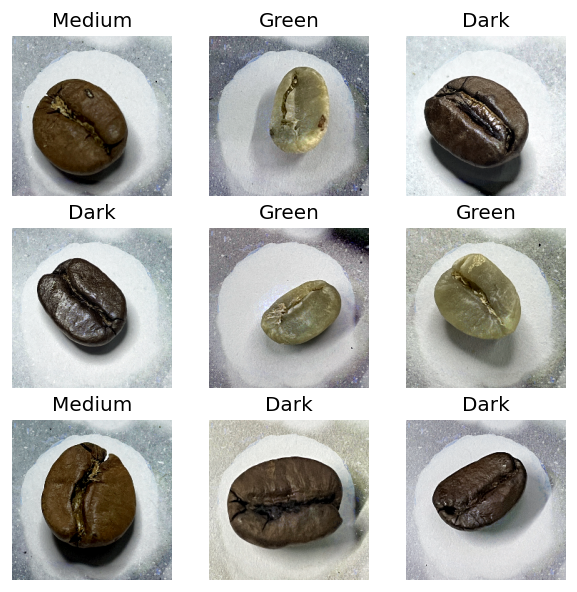

In [17]:
plt.figure(figsize = (6, 6), dpi = 120)
for i in range(9):
  index = random.randint(0, len(X_train_scaled))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_scaled[index])
  plt.title(class_names[y_train[index]])
  plt.axis(False)

❗ There is a wierd problem with this data being normalized using MinMaxScaler!!! I have not encountered this problem before. It seems that this problem caused by scaler transforming each column independently. However, using the exact same method did not cause such problem on other datasets I have worked on! 

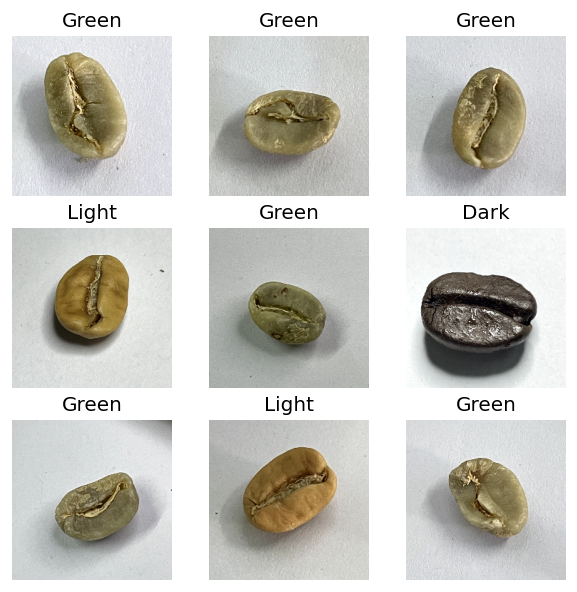

In [18]:
X_train_scaled = X_train / 255.0

plt.figure(figsize = (6, 6), dpi = 120)
for i in range(9):
  index = random.randint(0, len(X_train_scaled))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train_scaled[index])
  plt.title(class_names[y_train[index]])
  plt.axis(False)

✅ Normalizing images by dividing all the values by 255.0 works properly, unlike sklearn MinMaxScaler class.

In [19]:
X_val_scaled = X_val / 255.0
X_test_scaled = X_test / 255.0

### Fitting CNN on the train data

In [20]:
tf.random.set_seed(42)

cnn_1 = keras.Sequential([
    layers.Conv2D(filters = 20, kernel_size = 5, input_shape = (224, 224, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 12, kernel_size = 3, padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(len(class_names), activation = 'softmax')
])

cnn_1.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_1 = cnn_1.fit(X_train_scaled, y_train, epochs = 10, validation_data = (X_val_scaled, y_val))

Epoch 1/10
34/34 [==============================] - 14s 56ms/step - loss: 1.3713 - accuracy: 0.4731 - val_loss: 0.5696 - val_accuracy: 0.7167
Epoch 2/10
34/34 [==============================] - 1s 43ms/step - loss: 0.3510 - accuracy: 0.8648 - val_loss: 0.1983 - val_accuracy: 0.9500
Epoch 3/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0904 - accuracy: 0.9704 - val_loss: 0.0914 - val_accuracy: 0.9833
Epoch 4/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0343 - accuracy: 0.9926 - val_loss: 0.0904 - val_accuracy: 0.9917
Epoch 5/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0281 - accuracy: 0.9917 - val_loss: 0.1432 - val_accuracy: 0.9583
Epoch 6/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0136 - accuracy: 0.9972 - val_loss: 0.0602 - val_accuracy: 0.9917
Epoch 7/10
34/34 [==============================] - 1s 42ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9833
Epoch 8/10
3

In [21]:
cnn_1.evaluate(X_test_scaled, y_test)

13/13 [==============================] - 0s 32ms/step - loss: 0.0011 - accuracy: 1.0000


[0.0010681956773623824, 1.0]

In [22]:
def plot_loss_curve(history_df):
  plt.figure(figsize = (6, 4), dpi = 120)
  plt.plot(range(1, len(history_df) + 1), history_df['loss'], label = 'Training Loss')
  plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], label = 'Validation Loss')
  plt.title('Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Categorical Cross Entropy')
  plt.legend()
  plt.grid()
  plt.show()

In [23]:
def plot_accuracy_curve(history_df):
  plt.figure(figsize = (6, 4), dpi = 120)
  plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], label = 'Training Accuracy')
  plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], label = 'Validation Accuracy')
  plt.title('Accuracy Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  plt.show()

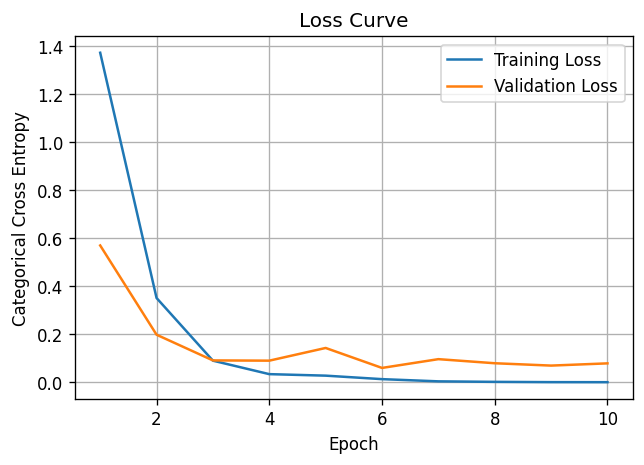

In [24]:
history_1_df = pd.DataFrame(history_1.history)

plot_loss_curve(history_1_df)

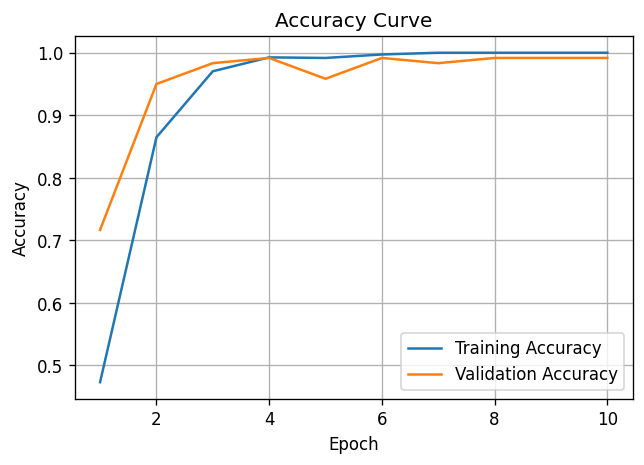

In [25]:
plot_accuracy_curve(history_1_df)

--- I believe that there is a slight tendency to overfitting based on the plots above. Although the model performed equally well on all three sets, its performance on validation set falls behind its performance on the training set.

In [30]:
tf.random.set_seed(42)

cnn_2 = keras.Sequential([
    layers.Conv2D(filters = 20, kernel_size = 5, input_shape = (224, 224, 3), padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 12, kernel_size = 3, padding = 'valid', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(len(class_names), activation = 'softmax')
])

cnn_2.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_2 = cnn_2.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
34/34 [==============================] - 2s 52ms/step - loss: 1.3330 - accuracy: 0.4519 - val_loss: 0.5818 - val_accuracy: 0.8333
Epoch 2/20
34/34 [==============================] - 1s 42ms/step - loss: 0.2609 - accuracy: 0.9176 - val_loss: 0.1124 - val_accuracy: 0.9917
Epoch 3/20
34/34 [==============================] - 1s 42ms/step - loss: 0.0733 - accuracy: 0.9787 - val_loss: 0.1842 - val_accuracy: 0.9417
Epoch 4/20
34/34 [==============================] - 1s 42ms/step - loss: 0.0614 - accuracy: 0.9769 - val_loss: 0.0709 - val_accuracy: 0.9917
Epoch 5/20
34/34 [==============================] - 1s 42ms/step - loss: 0.0235 - accuracy: 0.9944 - val_loss: 0.0825 - val_accuracy: 0.9833
Epoch 6/20
34/34 [==============================] - 1s 42ms/step - loss: 0.0207 - accuracy: 0.9944 - val_loss: 0.1720 - val_accuracy: 0.9417
Epoch 7/20
34/34 [==============================] - 1s 42ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.1335 - val_accuracy: 0.9750
Epoch 8/20
34

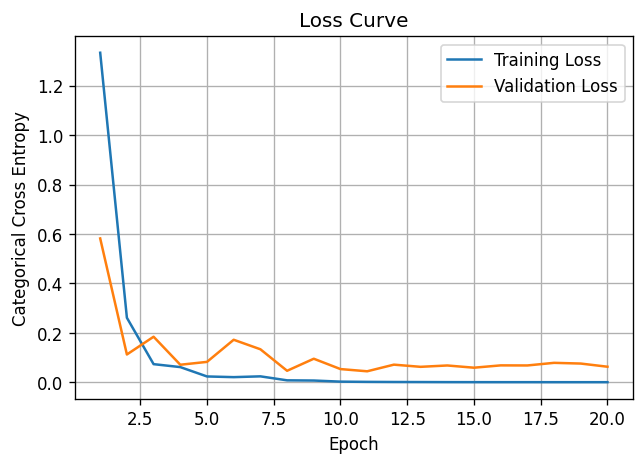

In [31]:
history_2_df = pd.DataFrame(history_2.history)

plot_loss_curve(history_2_df)

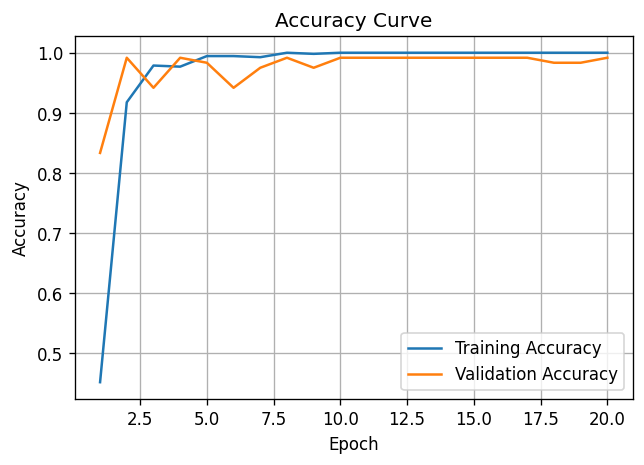

In [33]:
plot_accuracy_curve(history_2_df)

--- It can be seen that using a dropout and training for more epochs made the model slightly better in terms of consistency. Now let's check if the model performance on the test set is also satisfactory.

In [34]:
cnn_2.evaluate(X_test_scaled, y_test)

13/13 [==============================] - 0s 25ms/step - loss: 2.9398e-04 - accuracy: 1.0000


[0.0002939811092801392, 1.0]

--- Performance on the test set improved significantly regarding loss.

### Evaluating the model

In [51]:
y_proba = cnn_2.predict(X_test_scaled)
y_pred = np.argmax(y_proba, axis = 1)

In [37]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



--- As the model predicted all the test samples correctly, drawing confusion matrix won't give any useful information about the performance of the model.

In [41]:
def plot_random_image(image_set, true_labels, predictions, probabilities, class_names):
  
  index = random.randint(0, len(image_set))
  img = image_set[index]
  label = class_names[true_labels[index]]
  prediction = class_names[predictions[index]]
  proba = np.max(probabilities[index])

  
  c = 'g' if label == prediction else 'r'

  plt.imshow(img)
  plt.title(f'Predicted : {prediction}   {round(100 * proba, 2)}%   /   True label : {label}', color = c)
  plt.axis(False)

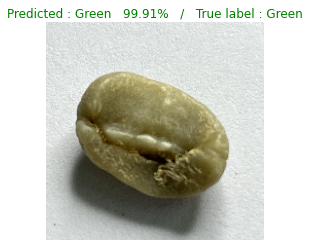

In [52]:
plot_random_image(X_test_scaled, y_test, y_pred, y_proba, class_names)

### Final Model Summary

In [53]:
cnn_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 20)      1520      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 20)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 12)      2172      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 12)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 34992)             0         
                                                                 
 dropout_1 (Dropout)         (None, 34992)            